In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os

from keras.utils import to_categorical
from sklearn import preprocessing

from tqdm import tqdm
from dltk.io.preprocessing import *

C:\Users\wogur\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
root = '../dataset/'
ct_set = os.path.join(root,'ct_train_test/ct_train/')
mr_set = os.path.join(root,'mr_train_test/mr_train/')

class_num=7+1 # background

In [3]:
ct_list = os.listdir(ct_set)
ct_images = list()
ct_labels = list()
for ct_l in ct_list:
    if 'image' in ct_l:
        file_path = os.path.join(ct_set, ct_l)
        fn = os.listdir(file_path)
        ct_images.append(nib.load(file_path + '/' + fn[0]))
    elif 'label' in ct_l:
        file_path = os.path.join(ct_set, ct_l)
        fn = os.listdir(file_path)
        ct_labels.append(nib.load(file_path + '/' + fn[0]))

In [4]:
mr_list = os.listdir(mr_set)
mr_images = list()
mr_labels = list()
for mr_l in mr_list:
    if 'image' in mr_l:
        file_path = os.path.join(mr_set, mr_l)
        fn = os.listdir(file_path)
        mr_images.append(nib.load(file_path + '/' + fn[0]))
    elif 'label' in mr_l:
        file_path = os.path.join(mr_set, mr_l)
        fn = os.listdir(file_path)
        mr_labels.append(nib.load(file_path + '/' + fn[0]))

In [5]:
ct_cnt = len(ct_images)
mr_cnt = len(mr_images)

# image shape

In [6]:
ct_size = list()
mr_size = list()
for ct_image in ct_images:
    ct_size.append(ct_image.shape)    
for mr_image in mr_images:
    mr_size.append(mr_image.shape)

In [7]:
ct_size

[(512, 512, 363),
 (512, 512, 239),
 (512, 512, 298),
 (512, 512, 200),
 (512, 512, 177),
 (512, 512, 248),
 (512, 512, 243),
 (512, 512, 222),
 (512, 512, 293),
 (512, 512, 274),
 (512, 512, 239),
 (512, 512, 177),
 (512, 512, 211),
 (512, 512, 358),
 (512, 512, 300),
 (512, 512, 333),
 (512, 512, 283),
 (512, 512, 187),
 (512, 512, 297),
 (512, 512, 363)]

In [8]:
mr_size

[(512, 512, 160),
 (512, 512, 128),
 (288, 288, 160),
 (288, 288, 120),
 (288, 288, 130),
 (256, 256, 160),
 (288, 288, 180),
 (288, 288, 130),
 (512, 512, 120),
 (288, 288, 160),
 (288, 288, 160),
 (512, 512, 128),
 (512, 512, 112),
 (512, 512, 160),
 (340, 340, 200),
 (288, 288, 130),
 (288, 288, 140),
 (288, 288, 150),
 (288, 288, 135),
 (288, 288, 135)]

# Fix label values

MR label의 10번째 image에 잘못된 값이 들어가있다.  
label:  [  0 205 420 421 500 550 600 820 850]  
cnt:  [15494952   312719   110267    11667   245762   190593   187564   162053    61639]

신기한 점은 get_data()로 다른 변수에 array를 할당한 후에 값을 변경하면 get_data()를 할당한 mr_labels[9]의 값도 바껴있다.

In [9]:
m = mr_labels[9].get_data()
m[m==421] = 420

# image resize

-----
# CT
## Images

In [10]:
ct_pad_images = np.zeros((len(ct_images),256,256,256,1))
for i in tqdm(range(len(ct_images))):
    img = ct_images[i].get_data()
    ct_pad_images[i,:,:,:,:] =  resize_image_with_crop_or_pad(img, [256, 256, 256], mode='symmetric').reshape(256,256,256,1)
del(ct_pad_images)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.65it/s]


## Labels

In [11]:
ct_pad_labels = np.zeros((len(ct_labels),256,256,256,8))
label_encoder = preprocessing.LabelEncoder()
for i in tqdm(range(len(ct_labels))):
    img = ct_labels[i].get_data()    
    img = resize_image_with_crop_or_pad(img, [256, 256, 256], mode='symmetric') 
    
    # encoder
    raw_shape = img.shape
    img = img.reshape(-1)
    img = label_encoder.fit_transform(img)
    img = to_categorical(img, class_num)
    
    # reshape to raw shape
    img = img.reshape((1,) + raw_shape + (class_num,))
    
    ct_pad_labels[i,:,:,:,:] =  img
del(ct_pad_labels)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:30<00:00,  1.50s/it]


------
# MR

## Images

In [ ]:
mr_pad_images = np.zeros((len(mr_images),256,256,256,1))
for i in tqdm(range(len(mr_images))):
    img = mr_images[i].get_data()
    mr_pad_images[i,:,:,:,:] =  resize_image_with_crop_or_pad(img, [256, 256, 256], mode='symmetric').reshape(256,256,256,1)
del(mr_pad_images)

## Labels

In [13]:
mr_pad_labels = np.zeros((len(mr_labels),256,256,256,8))
label_encoder = preprocessing.LabelEncoder()
for i in tqdm(range(len(mr_labels))):
    img = mr_labels[i].get_data()
    img = resize_image_with_crop_or_pad(img, [256, 256, 256], mode='symmetric')
    
    # encoder
    raw_shape = img.shape
    img = img.reshape(-1)
    
    img = label_encoder.fit_transform(img)
    label, cnt = np.unique(img,return_counts=True)
    img = to_categorical(img, class_num)
    
    # reshape to raw shape
    img = img.reshape((1,) + raw_shape + (class_num,))
    
    mr_pad_labels[i,:,:,:,:] =  img
del(mr_pad_labels)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:33<00:00,  1.70s/it]


### 1. Check resize

In [11]:
ct_pad_images = np.zeros((len(ct_images[:20]),256,256,256,1))
for i in tqdm(range(len(ct_images[:20]))):
    img = ct_images[i].get_data()
    ct_pad_images[i,:,:,:,:] =  resize_image_with_crop_or_pad(img, [256, 256, 256], mode='symmetric').reshape(256,256,256,1)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.57it/s]


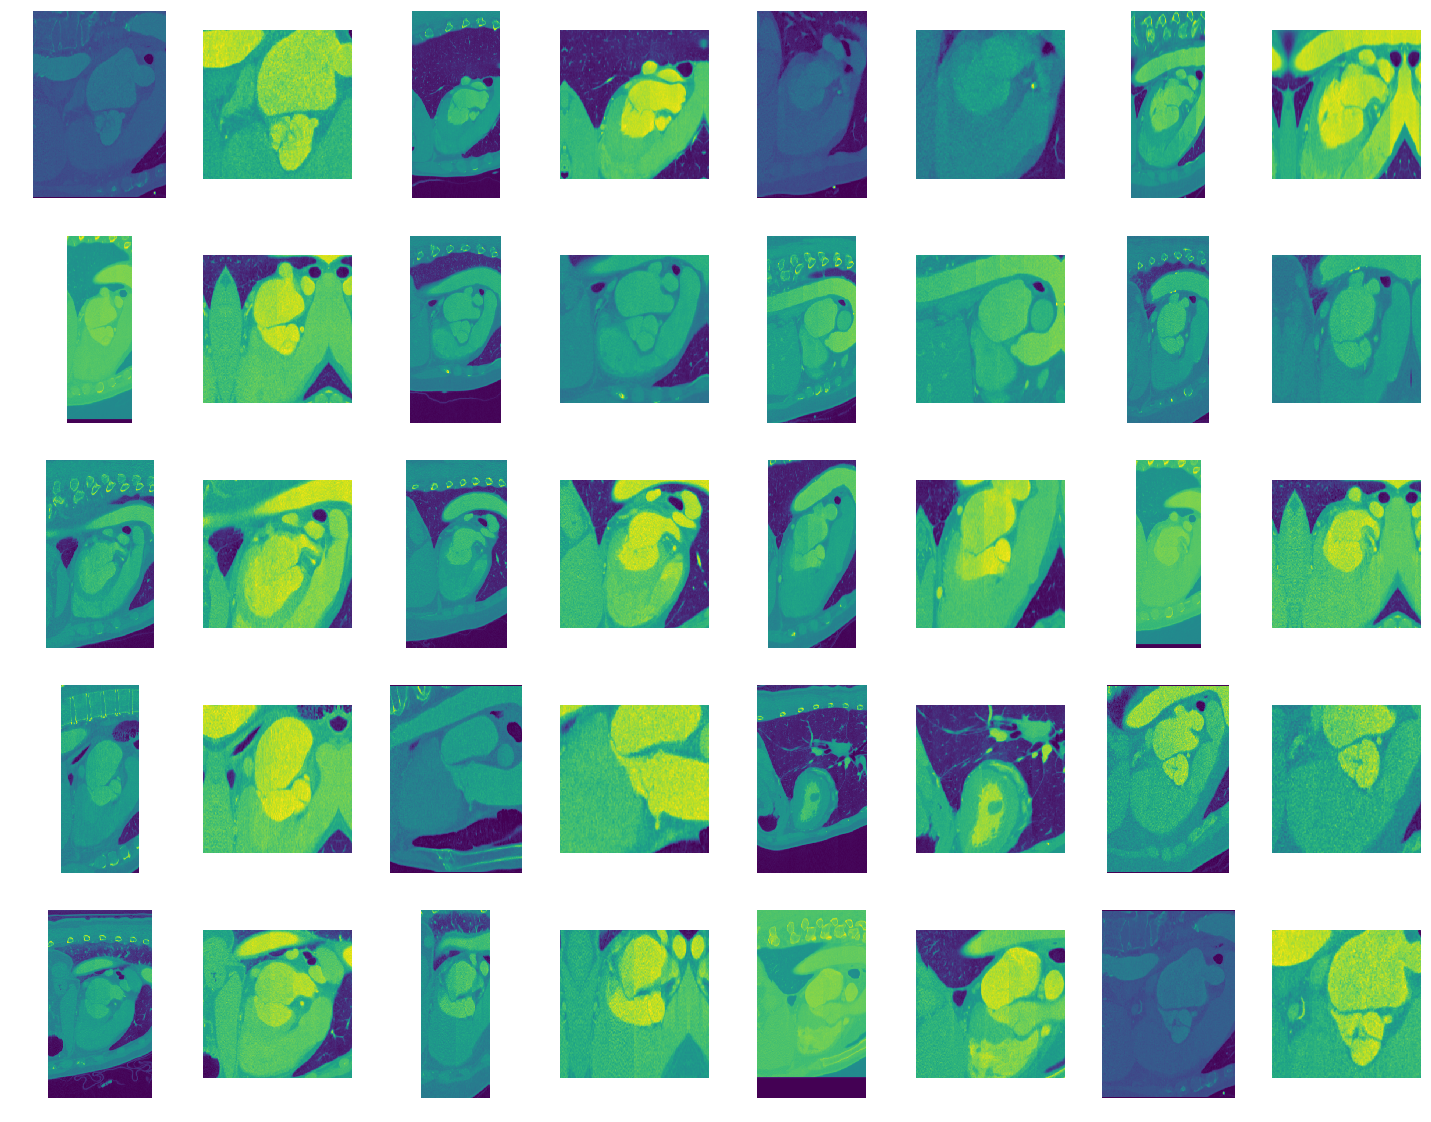

In [27]:
f, ax = plt.subplots(5,8, figsize=(25,20))
img_idx = 0
pad_idx = 0
for i in range(5*8):
    if (i%8)%2==0:
        ax[i//8,i%8].imshow(ct_images[img_idx].get_data()[256,:,:])
        ax[i//8,i%8].axis('off')
        img_idx+=1
    else:
        img = ct_pad_images[pad_idx].reshape(ct_pad_images[pad_idx].shape[:-1])
        ax[i//8,i%8].imshow(img[128,:,:])
        ax[i//8,i%8].axis('off')
        pad_idx+=1

### 2. Check image & label matching

In [15]:
ct_pad_labels = np.zeros((len(ct_labels[:20]),256,256,256,8))
label_encoder = preprocessing.LabelEncoder()
for i in tqdm(range(len(ct_labels[:20]))):
    img = ct_labels[i].get_data()
    img = resize_image_with_crop_or_pad(img, [256, 256, 256], mode='symmetric')
    
    # encoder
    raw_shape = img.shape
    img = img.reshape(-1)
    
    img = label_encoder.fit_transform(img)
    label, cnt = np.unique(img,return_counts=True)
    img = to_categorical(img, class_num)
    
    # reshape to raw shape
    img = img.reshape((1,) + raw_shape + (class_num,))
    
    ct_pad_labels[i,:,:,:,:] =  img

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:35<00:00,  1.76s/it]


In [16]:
label, cnt = np.unique(ct_pad_labels[0],return_counts=True)
print('label: ',label)
print('cnt: ',cnt)

label:  [0. 1.]
cnt:  [117440512  16777216]


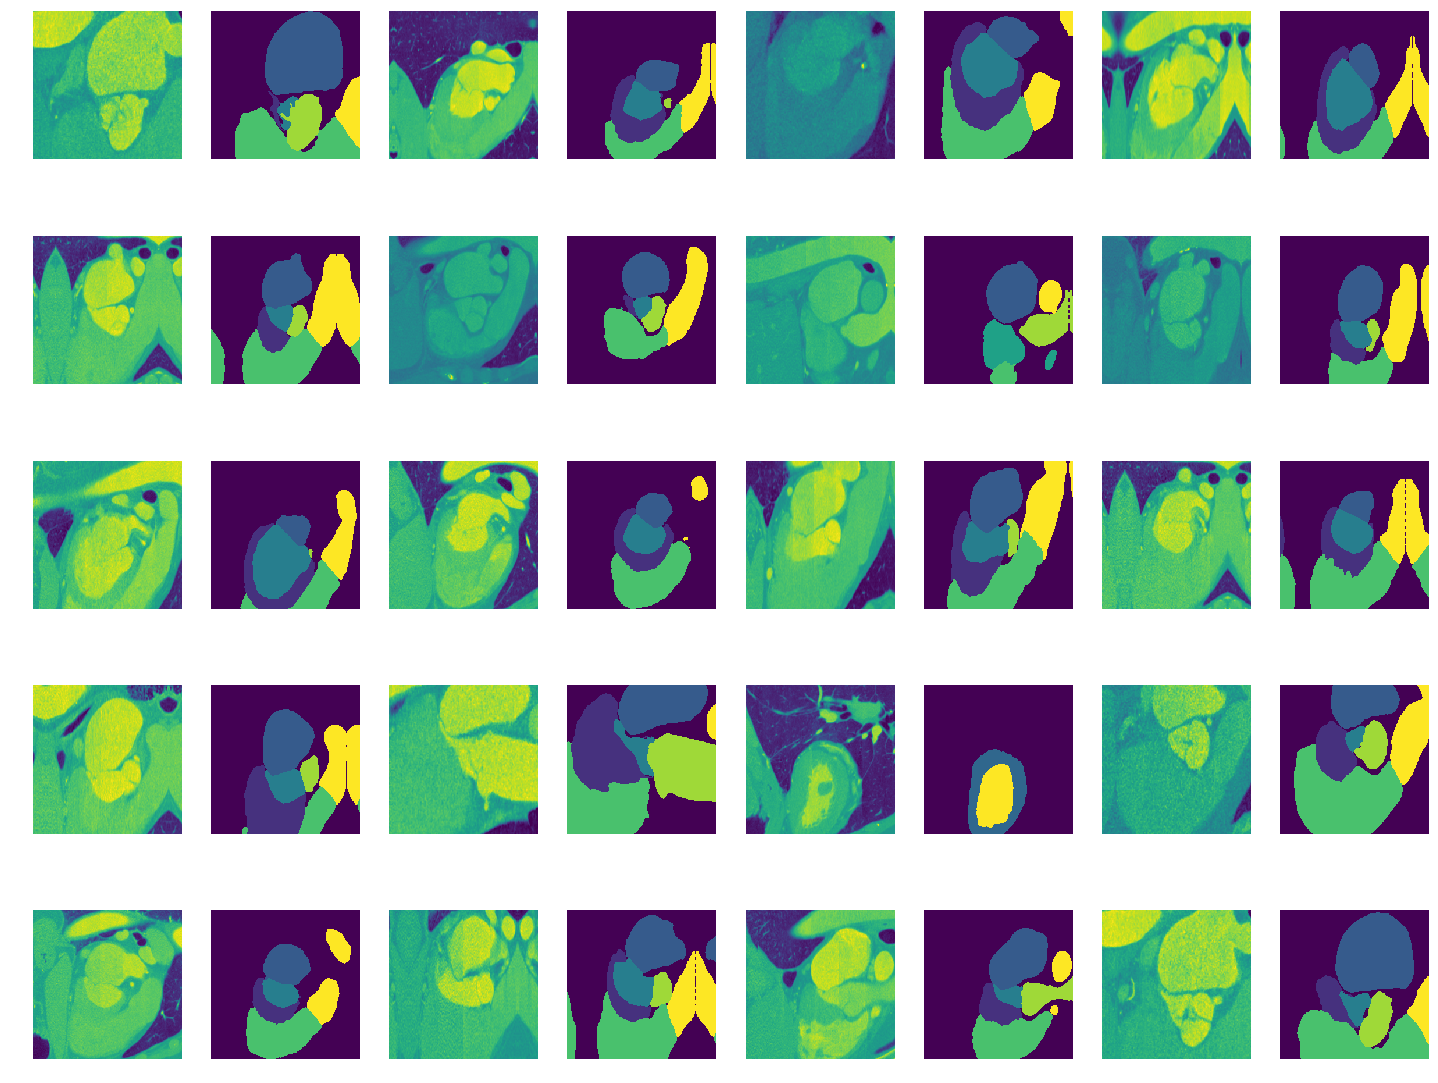

In [17]:
f, ax = plt.subplots(5,8, figsize=(25,20))
img_idx = 0
pad_idx = 0
for i in range(5*8):
    if (i%8)%2==0:
        img = ct_pad_images[pad_idx].reshape(ct_pad_images[pad_idx].shape[:-1])
        ax[i//8,i%8].imshow(img[128,:,:])
        ax[i//8,i%8].axis('off')
        img_idx+=1
    else:
        mask = np.argmax(ct_pad_labels[pad_idx], axis=-1)
        ax[i//8,i%8].imshow(mask[128,:,:])
        ax[i//8,i%8].axis('off')
        pad_idx+=1

In [28]:
img = ct_images[0].get_data()
print('before shape: ',img.shape)
resized_img = resize_image_with_crop_or_pad(img, [256, 256, 256], mode='symmetric')

print('after shape: ',resized_img.shape)
img = nib.Nifti1Image(resized_img, affine=np.eye(4))
nib.save(img,'../dataset/ct_imgs.nii')

before shape:  (512, 512, 363)
after shape:  (256, 256, 256)


In [29]:
img = mr_images[0].get_data()
print('before shape: ',img.shape)
resized_img = resize_image_with_crop_or_pad(img, [256, 256, 256], mode='symmetric')

print(resized_img.shape)
img = nib.Nifti1Image(resized_img, affine=np.eye(4))
nib.save(img,'../dataset/mr_imgs.nii')

before shape:  (512, 512, 160)
(256, 256, 256)


In [30]:
mask = ct_labels[0].get_data()
print('before shape: ',mask.shape)
resized_mask = resize_image_with_crop_or_pad(mask, [256, 256, 256], mode='symmetric')

print('after shape: ',resized_mask.shape)
img = nib.Nifti1Image(resized_mask, affine=np.eye(4))
nib.save(img,'../dataset/ct_labels.nii')

before shape:  (512, 512, 363)
after shape:  (256, 256, 256)


In [31]:
mask = mr_labels[0].get_data()
print('before shape: ',mask.shape)
resized_mask = resize_image_with_crop_or_pad(mask, [256, 256, 256], mode='symmetric')

print('after shape: ',resized_mask.shape)
img = nib.Nifti1Image(resized_mask, affine=np.eye(4))
nib.save(img,'../dataset/mr_labels.nii')

before shape:  (512, 512, 160)
after shape:  (256, 256, 256)


# Test image

In [ ]:
ct_test_dir = '../dataset/ct_train_test/ct_test/'
ct_test_list = os.listdir(ct_test_dir)
ct_test_pad_images = list()

mr_test_dir = '../dataset/mr_train_test/mr_test/'
mr_test_list = os.listdir(mr_test_dir)
mr_test_pad_images = list()

In [ ]:
ct_test_images = list()
for fn in ct_test_list:
    img_dir = os.path.join(ct_test_dir,fn)
    img_fn = os.listdir(img_dir)[0]
    im = nib.load(os.path.join(img_dir, img_fn))
    ct_test_images.append(im)
    
mr_test_images = list()
for fn in mr_test_list:
    img_dir = os.path.join(mr_test_dir,fn)
    img_fn = os.listdir(img_dir)[0]
    im = nib.load(os.path.join(img_dir, img_fn))
    mr_test_images.append(im)

In [ ]:
print('='*100)
print('CT')
print('='*100)
for img in ct_test_images:
    print(img.shape)
    
print('='*100)
print('MR')
print('='*100)
for img in mr_test_images:
    print(img.shape)

In [ ]:
f, ax = plt.subplots(1,5,figsize=(30,10))
for i in range(5):
    ax[i].imshow(ct_test_images[i].get_data()[256,:,:])
    ax[i].axis('off')

In [ ]:
ct_test_pad_images = np.zeros((len(ct_test_images),256,256,256,1))
for i in tqdm(range(len(ct_test_images))):
    img = ct_test_images[i].get_data()
    ct_test_pad_images[i,:,:,:,:] =  resize_image_with_crop_or_pad(img, [256, 256, 256], mode='symmetric').reshape(256,256,256,1)
del(ct_test_pad_images)

In [ ]:
mr_test_pad_images = np.zeros((len(mr_test_images),256,256,256,1))
for i in tqdm(range(len(mr_test_images))):
    img = mr_test_images[i].get_data()
    mr_test_pad_images[i,:,:,:,:] =  resize_image_with_crop_or_pad(img, [256, 256, 256], mode='symmetric').reshape(256,256,256,1)
del(mr_test_pad_images)